In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

from IPython import display

In [ ]:
datapath="/content/drive/MyDrive/COE project/De Guzman/input"

In [ ]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/COE project/De Guzman/input/ro_ru",label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 165 files belonging to 1 classes.


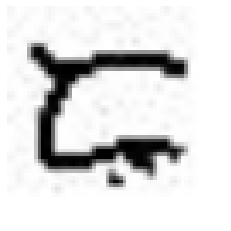

In [ ]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("/content/drive/MyDrive/COE project/De Guzman/output/ro-ru/img_%03d_%d.png" % (epoch, i))

In [ ]:
epochs = 1000

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=1, latent_dim=latent_dim)]
)

Epoch 1/1000
6/6 [==============================] - 17s 406ms/step - d_loss: 0.6494 - g_loss: 0.6102
Epoch 2/1000
6/6 [==============================] - 2s 224ms/step - d_loss: 0.5792 - g_loss: 0.6564
Epoch 3/1000
6/6 [==============================] - 2s 222ms/step - d_loss: 0.4946 - g_loss: 0.8568
Epoch 4/1000
6/6 [==============================] - 2s 221ms/step - d_loss: 0.3841 - g_loss: 1.0735
Epoch 5/1000
6/6 [==============================] - 2s 219ms/step - d_loss: 0.2552 - g_loss: 1.4783
Epoch 6/1000
6/6 [==============================] - 2s 222ms/step - d_loss: 0.1782 - g_loss: 1.8922
Epoch 7/1000
6/6 [==============================] - 2s 222ms/step - d_loss: 0.1989 - g_loss: 1.6873
Epoch 8/1000
6/6 [==============================] - 2s 222ms/step - d_loss: 0.3691 - g_loss: 0.9176
Epoch 9/1000
6/6 [==============================] - 2s 221ms/step - d_loss: 0.4081 - g_loss: 0.7591
Epoch 10/1000
6/6 [==============================] - 2s 221ms/step - d_loss: 0.3778 - g_loss: 0.819

In [ ]:
#plt.figure(figsize=(10,5))
#plt.title("Generator and Discriminator Loss During Training")
#plt.plot(g_loss_metric,label="G_loss")
#plt.plot(d_loss_metric,label="D_Loss")
#plt.xlabel("iterations")
#plt.ylabel("Loss")
#plt.legend()
#plt.show()

In [ ]:
import glob
from PIL import Image

# filepaths
fp_in = "/content/drive/MyDrive/COE project/De Guzman/output/ro-ru/*.png"
fp_out = "/content/drive/MyDrive/COE project/De Guzman/output/ro-ru/ro-ru.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=2, loop=1)

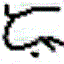

In [ ]:
from IPython.display import Image;

Image("/content/drive/MyDrive/COE project/De Guzman/output/ro-ru/ro-ru.gif")

In [ ]:
print(history.history.keys())

dict_keys(['d_loss', 'g_loss'])


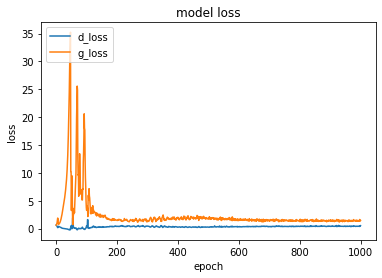

In [ ]:
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['d_loss', 'g_loss'], loc='upper left')
plt.show()

In [ ]:
print(history.history['d_loss'])

[0.6494275331497192, 0.5792073011398315, 0.4946441352367401, 0.38413384556770325, 0.2551526129245758, 0.17818725109100342, 0.19890834391117096, 0.369054913520813, 0.4081393778324127, 0.37781763076782227, 0.3486146628856659, 0.319564551115036, 0.28849369287490845, 0.25762978196144104, 0.21508608758449554, 0.2056318074464798, 0.20642851293087006, 0.14711201190948486, 0.11385881155729294, 0.10706919431686401, 0.0638597160577774, 0.056223105639219284, 0.041366446763277054, 0.030005821958184242, 0.025074144825339317, 0.01785963773727417, 0.0060844519175589085, -0.005191742442548275, -0.004465346224606037, -0.016395919024944305, -0.014602750539779663, -0.025352975353598595, -0.030270105227828026, -0.033434074372053146, -0.04705864191055298, -0.0649532899260521, -0.08133556693792343, -0.07294072955846786, -0.10505317896604538, -0.12327579408884048, -0.15361160039901733, -0.16360168159008026, -0.19332019984722137, -0.1535969376564026, -0.20095521211624146, -0.23311235010623932, -0.095015257596

In [ ]:
print(history.history['g_loss'])

[0.6101948618888855, 0.6564396023750305, 0.8567653298377991, 1.0734933614730835, 1.4782614707946777, 1.8922066688537598, 1.6873120069503784, 0.9176321029663086, 0.7590704560279846, 0.8191171288490295, 0.877478837966919, 0.9549686312675476, 1.0497859716415405, 1.1805318593978882, 1.3682655096054077, 1.5996065139770508, 1.725317120552063, 2.03534197807312, 2.27779221534729, 2.513390302658081, 2.892327308654785, 3.1798133850097656, 3.507220983505249, 3.8518917560577393, 4.176593780517578, 4.489501476287842, 4.858981609344482, 5.185920715332031, 5.582198619842529, 5.997680187225342, 6.449161052703857, 6.95375394821167, 7.508689880371094, 8.133923530578613, 8.812250137329102, 9.615662574768066, 10.58070182800293, 11.766358375549316, 13.138838768005371, 14.810379981994629, 16.86275863647461, 19.43503761291504, 22.266149520874023, 24.426958084106445, 28.328336715698242, 31.506540298461914, 33.00633239746094, 35.23225402832031, 10.211588859558105, 10.187247276306152, 3.246149778366089, 7.13705

In [ ]:
import math
g_loss = history.history['g_loss']
d_loss = history.history['d_loss']
g_sum = 0
d_sum = 0
for ele in g_loss:
  g_sum += ele
g_res = g_sum / len(g_loss)

for ele in d_loss:
  d_sum += ele
d_res = d_sum / len(d_loss)  

# printing result 
print("Average generator loss: " + str(g_res))
print("Average discriminator loss: " + str(d_res))

Average generator loss: 2.384870021104813
Average discriminator loss: 0.3432923235516064
